# Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm


# Custom function

In [2]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

# example default print
msg='test of default colors'
print_in_color(msg)

test of default colors



### Generate training, testing, and validation dataframes from testing and training directories
* Create a dataframe of image paths and class labels by reading in images

In [3]:
def make_dataframes(train_dir, test_dir): 
    dirlist=[train_dir, test_dir]
    names=['train', 'test']
    ziplist=zip(names, dirlist)
    for name, directory in ziplist:        
        filepaths=[]
        labels=[]
        classlist=sorted(os.listdir(directory) )       
        for klass in classlist:
            classpath=os.path.join(directory, klass)           
            flist=sorted(os.listdir(classpath)) 
            desc=f'{name:6s}-{klass:25s}'
            for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
        Fseries=pd.Series(filepaths, name='filepaths')
        Lseries=pd.Series(labels, name='labels')
        df=pd.concat([Fseries, Lseries], axis=1) 
        if name == 'train':
            pdf=df            
        else:
            test_df=df
    train_df, valid_df=train_test_split(pdf, train_size=.8, shuffle=True, random_state=123, stratify=pdf['labels'])
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts())    
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)    
    return train_df, test_df, valid_df, classes, class_count
    

In [4]:
train_dir=r'/content/drive/MyDrive/0_data_science/mri_brain_tumor/cropped/Training'
test_dir=r'/content/drive/MyDrive/0_data_science/mri_brain_tumor/cropped/Testing'
train_df, test_df, valid_df, classes, class_count=make_dataframes(train_dir, test_dir)

test  -pituitary                : 100%|██████████████████████████████████████████████████| 300/300 [00:00<00:00, 245376.60files/s]


number of classes in processed dataset=  4
the maximum files in any class in train_df is  1276   the minimum files in any class in train_df is  1057
train_df length:  4569   test_df length:  1311   valid_df length:  1143
average image height=  256   average image width=  256  aspect ratio h/w=  1.0


In [5]:
#train dataframe samples:
train_df.head(2)

,filepaths,labels
2209,/content/drive/MyDrive/0_data_science/mri_brai...,meningioma
907,/content/drive/MyDrive/0_data_science/mri_brai...,glioma


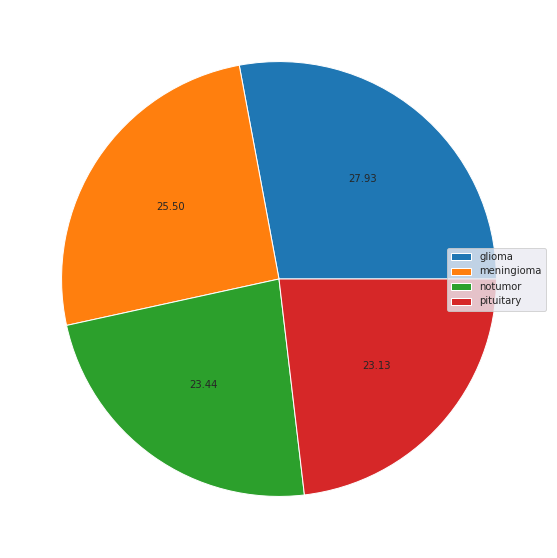

In [6]:
def autopct(pct): # only show the label when it's > 10%
    return ('%.2f' % pct) if pct > 10 else ''
ax = train_df['labels'].value_counts().plot(kind='pie', figsize=(10,10), autopct=autopct, labels=None)
ax.axes.get_yaxis().set_visible(False)
plt.legend(loc=5, labels=classes)

In [7]:
#test dataframe samples:
test_df.head(2)

,filepaths,labels
0,/content/drive/MyDrive/0_data_science/mri_brai...,glioma
1,/content/drive/MyDrive/0_data_science/mri_brai...,glioma


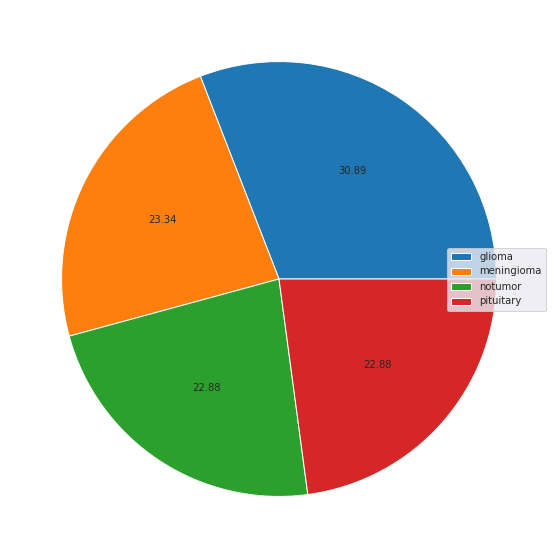

In [8]:
ax = test_df['labels'].value_counts().plot(kind='pie', figsize=(10,10), autopct=autopct, labels=None)
ax.axes.get_yaxis().set_visible(False)
plt.legend(loc=5, labels=classes)

In [9]:
#validation dataframe samples:
valid_df.head(2)

,filepaths,labels
2604,/content/drive/MyDrive/0_data_science/mri_brai...,meningioma
1210,/content/drive/MyDrive/0_data_science/mri_brai...,glioma


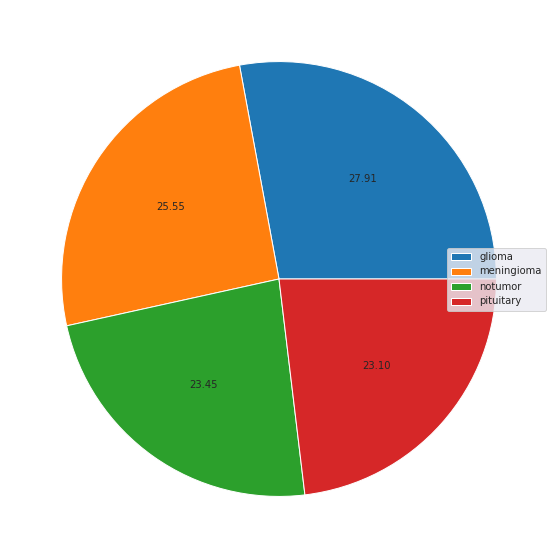

In [10]:
ax = valid_df['labels'].value_counts().plot(kind='pie', figsize=(10,10), autopct=autopct, labels=None)
ax.axes.get_yaxis().set_visible(False)
plt.legend(loc=5, labels=classes)

In [11]:
print(f'There are {class_count} classes in each dataset  \n{classes}')

There are 4 classes in each dataset  
['glioma', 'meningioma', 'notumor', 'pituitary']


### Manage the balance of the dataset by adding augmented images to minority classes
* Creating a new folder named 'new_aug' for storing augmented images
* Apply image augmentation by rotating, shifting, and flipping horizontally
* Merge newly augmented images paths and labels with existing dataframes for training/testing/validation

In [12]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'new_aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images  
    total=0
    #gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
    #                              height_shift_range=.2, zoom_range=.2)
    gen=ImageDataGenerator(rotation_range=10, width_shift_range=0.05, height_shift_range=0.05,horizontal_flip=True)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=os.listdir(classpath)    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df  


In [13]:
n=1600 # number of samples in each class
working_dir=r'/content/drive/MyDrive/0_data_science/mri_brain_tumor/0923copy/' # directory to store augmented images
img_size=(270,230) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size) 

Initial length of dataframe is  4569
Found 1071 validated image filenames.
Found 1057 validated image filenames.
Found 1276 validated image filenames.
Found 1165 validated image filenames.
Total Augmented images created=  1831
Length of augmented dataframe is now  6400


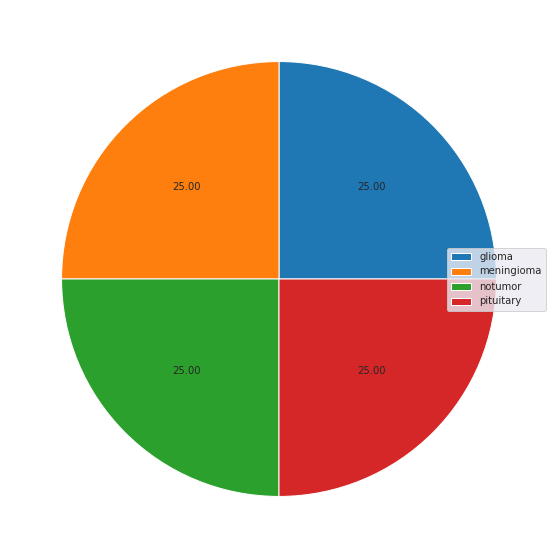

In [14]:
ax = train_df['labels'].value_counts().plot(kind='pie', figsize=(10,10), autopct=autopct, labels=None)
ax.axes.get_yaxis().set_visible(False)
plt.legend(loc=5, labels=classes)

### Generate batches of augmented/normalized data for training, testing and validation dataframes
* Using the flow_from_dataframe function, generate batches of tensor image data with real-time data augmentation
  * Tensorflow can use a dataframe to determine which images to use and what classification each image belongs to.

* In the test_gen, we want to calculate the batch size and test steps such that `batch_size` * `test_steps` = number of samples in the test set
  * By doing this, we ensure that we run through all sample sets exactly once.

In [15]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator(horizontal_flip=True)    
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes

In [16]:
batch_size=30
train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes=make_gens(batch_size, train_df, test_df, valid_df, img_size)

Found 6400 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.
test batch size:  69   test steps:  19  number of classes :  4


### Display examples of training images

* Display the first 25 images along with their labels of the first batch in training data generator


In [17]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()
    

In [18]:
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

In [19]:
train_gen[0][1]

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]], dtype=float32)

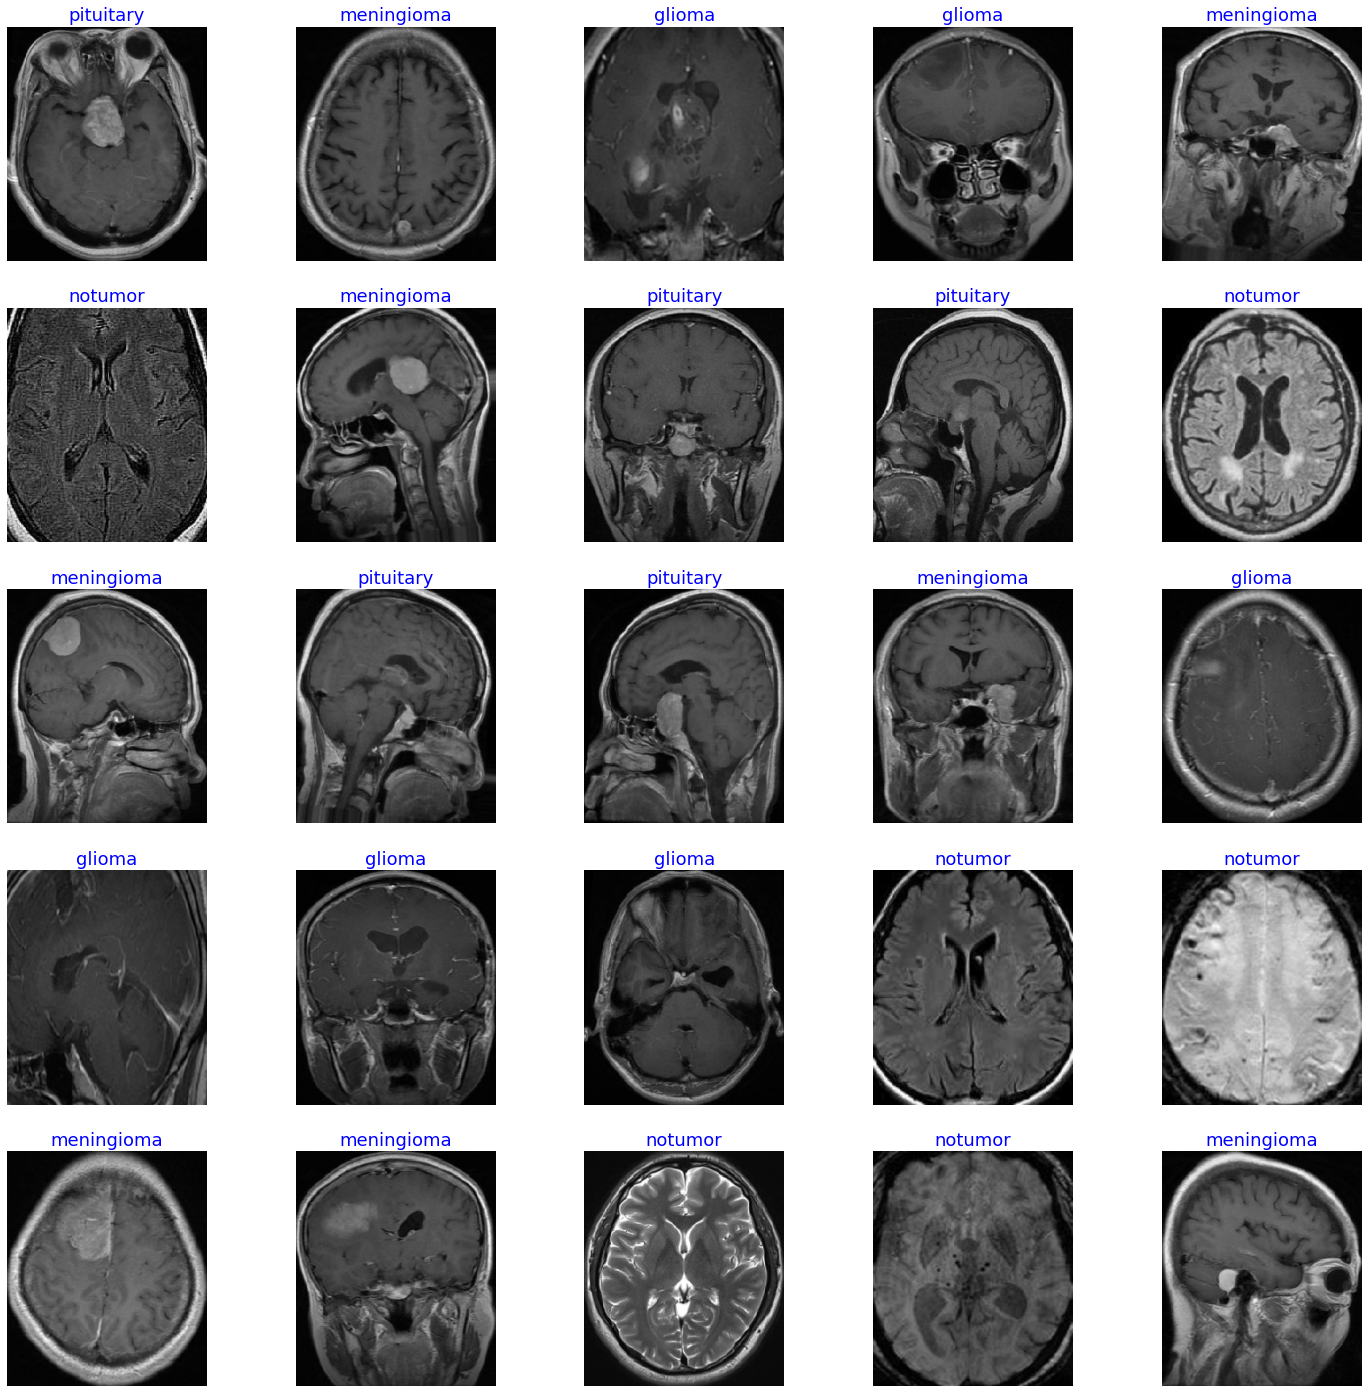

In [20]:
show_image_samples(train_gen)

### Create models using transfer learning with EfficientNet (B0,B3,B5,B7)
* Training our model using EfficientNet with transferred imagenet weights as a base model
* Removing the top layer from our base model and setting it to non-trainable
  * By doing this, we can pass the image data through the pretrained model and get an output
  *  Using this output as inputs for our additional dense layers, we will be able to train them.

In [21]:
def make_model(img_size, lr, mod_num=3):  
    img_shape=(img_size[0], img_size[1], 3)
    if mod_num == 0:
        base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Creating EfficientNet B0 model'
    elif mod_num == 3:
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Creating EfficientNet B3 model'
    elif mod_num == 5:
        base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Creating EfficientNet B5 model'
        
    else:
        base_model=tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Creating EfficientNet B7 model'   
    print_in_color(msg)
    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 
    return model

In [22]:
lr=.001
model=make_model(img_size, lr) # using B3 model by default

43950080/43941136 [==============================] - 0s 0us/step
Creating EfficientNet B3 model



### Custom model callback

When training is complete, the model weights are set to the epoch with the lowest validation loss.
`callbacks= LR_ASK(model, epochs,  ask_epoch, dwell=True, factor=.4)`
* model: A string representing the name of the compiled model
* epochs: An integer representing the number of epochs to run specified in model.fit
* ask_epochs: if ask_epochs = 10, the model will train for 10 epochs before asking for user input
*   User input: `h` or a number (integer value)
* `H` or `h': ex: `ask_epochs = h` the model training process would be halted
* A number (integer value): for example `ask_epochs = 5` would continue training for 5 epochs, then the user would be asked for the new value.
* dwell: a boolean value (True/False)
  * True: the model will keep track of the current epoch validation loss and compare it with the lowest validation loss so far.
    * If the current epoch validation loss is less than the lowest validation loss, the current epoch weights would be saved at the best weight
    * When the current epoch validation loss exceeds the lowest validation loss, the new learning rate would be lowered by multiplying the current learning rate by the `factor` (a float value between 0 & 1)


In [23]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.4): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor
        
    def get_list(self): # define a function to return the list of % validation change
        return self.plist, self.alist
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            msg =f'Training will proceed until epoch {ask_epoch} then you will be asked to' 
            print_in_color(msg )
            msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print_in_color(msg)
            if self.dwell:
                msg='learning rate will be automatically adjusted during training'
                print_in_color(msg)
        self.start_time= time.time() # set the time at which training started
       
    def on_train_end(self, logs=None):   # runs at the end of training  
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, (0,255,255))
        model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        if epoch >0:
            deltav = self.lowest_vloss- vloss 
            pimprov=(deltav/self.lowest_vloss) * 100 
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov=0.0 
            aimprov=0.0
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1            
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print_in_color(msg, (0,255,0)) # green foreground
        else: # validation loss increased
            pimprov=abs(pimprov)
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print_in_color(msg, (255,255,0)) # yellow foreground
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print_in_color(msg) # cyan foreground
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                model.set_weights(self.best_weights) # set the weights of the model to the best weights      
                
        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print_in_color(msg) # cyan foreground
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print_in_color(msg) # cyan foreground
                        if self.dwell==False:
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                            msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            print_in_color(msg) # cyan foreground
                            ans=input(' ')
                            if ans =='':
                                msg=f'keeping current LR of {lr:7.5f}'
                                print_in_color(msg) # cyan foreground
                            else:
                                new_lr=float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                                msg=f' changing LR to {ans}'
                                print_in_color(msg) # cyan foreground

# Instantiate custom callback

In [24]:
epochs=40
ask_epoch=10
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

# Train model

In [25]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 10 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/40
214/214 [==============================] - ETA: 0s - loss: 5.8624 - accuracy: 0.8923
 validation loss of  4.0635 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

214/214 [==============================] - 672s 3s/step - loss: 5.8624 - accuracy: 0.8923 - val_loss: 4.0635 - val_accuracy: 0.9361
Epoch 2/40
214/214 [==============================] - ETA: 0s - loss: 2.8434 - accuracy: 0.9727
 validation loss of  2.0284 is 50.0838 % below lowest loss, saving weights from epoch 2   as best weights

214/214 [==============================] - 115s 535ms/step - loss: 2.8434 - accuracy: 0.9727 - val_loss: 2.0284 - val_accuracy: 0.9676
Epoch 3/40
214/214 [==============================] - ETA: 0s - loss: 1.5238 - accuracy: 0.9816
 valida

# Define a function to plot the training data


In [48]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    return index_loss
    

### Display metrics (loss and accuracy) for training and validation
* Graph the change in validation accuracy values and validation loss values between training and validating datasets over time.


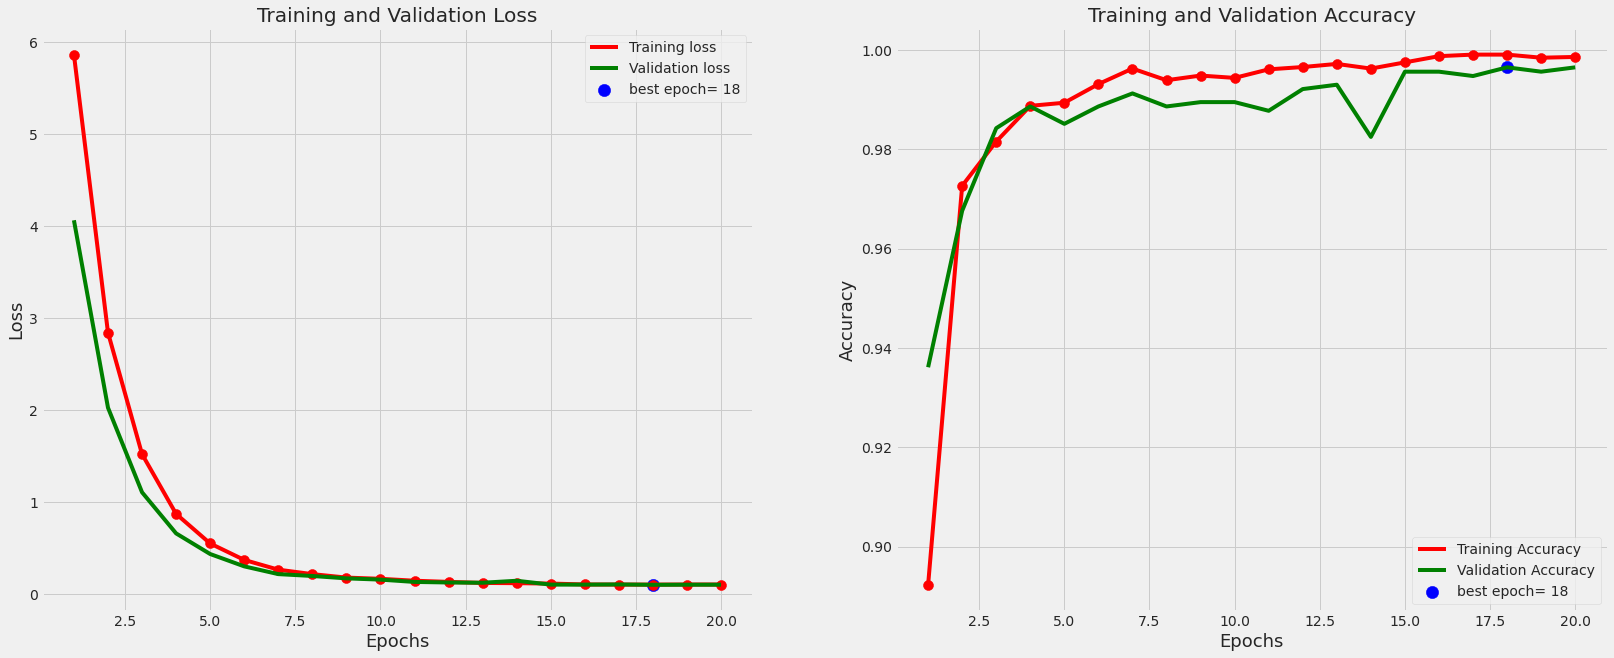

In [49]:
loss_index=tr_plot(history,0)

# Make Predictions on the test set
* Define a function which takes in a test generator and an integer test_steps
* Generates predictions on the test set including a confusion matric
* Generate classification report

In [50]:
def predictor(test_gen, test_steps):
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]
            error_list.append(file)
            error_class=classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, error_pred_list

19/19 [==============================] - 5s 256ms/step
there were 10 errors in 1311 tests for an accuracy of  99.24



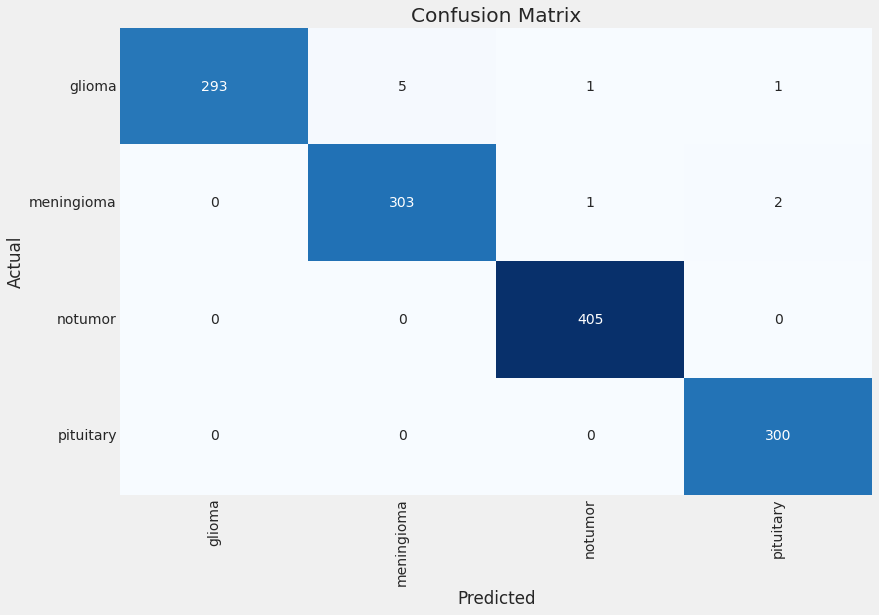

Classification Report:
----------------------
               precision    recall  f1-score   support

      glioma     1.0000    0.9767    0.9882       300
  meningioma     0.9838    0.9902    0.9870       306
     notumor     0.9951    1.0000    0.9975       405
   pituitary     0.9901    1.0000    0.9950       300

    accuracy                         0.9924      1311
   macro avg     0.9922    0.9917    0.9919      1311
weighted avg     0.9924    0.9924    0.9924      1311



In [51]:
errors, tests, error_list, error_pred_list =predictor(test_gen, test_steps)

In [52]:
if len(error_list) > 0:
    print ('Below is a list of test files that were miss classified \n')
    print ('{0:^30s}{1:^30s}'.format('Test File', ' Predicted as'))
    for i in range(len(error_list)):
        fpath=error_list[i]
        split=fpath.split('/')
        f=split[4]+ '-' + split[5]
        print(f'{f:^30s}{error_pred_list[i]:^30s}')

Below is a list of test files that were miss classified 

          Test File                    Predicted as         
0_data_science-mri_brain_tumor          pituitary           
0_data_science-mri_brain_tumor           notumor            
0_data_science-mri_brain_tumor          meningioma          
0_data_science-mri_brain_tumor          meningioma          
0_data_science-mri_brain_tumor          meningioma          
0_data_science-mri_brain_tumor          meningioma          
0_data_science-mri_brain_tumor          meningioma          
0_data_science-mri_brain_tumor           notumor            
0_data_science-mri_brain_tumor          pituitary           
0_data_science-mri_brain_tumor          pituitary           


# Save the model

In [53]:
working_dir=r'/content/drive/MyDrive/0_data_science/Saved_Models/Brain-Tumor-MRI/'
subject='0923brain_tumor_MRI' 
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) + '.h5' 
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)
msg= f'model was saved as {model_save_loc}'
print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground

model was saved as /content/drive/MyDrive/0_data_science/Saved_Models/Brain-Tumor-MRI/0923brain_tumor_MRI_99.23.h5



# Test the exported model

In [54]:
model= keras.models.load_model('/content/drive/MyDrive/0_data_science/Saved_Models/Brain-Tumor-MRI/0923brain_tumor_MRI_99.23.h5')

In [55]:
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

In [56]:
def predictor(test_gen, test_steps):
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]
            error_list.append(file)
            error_class=classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, error_pred_list,y_true,preds,ypred,ytrue

19/19 [==============================] - 7s 259ms/step
there were 10 errors in 1311 tests for an accuracy of  99.24



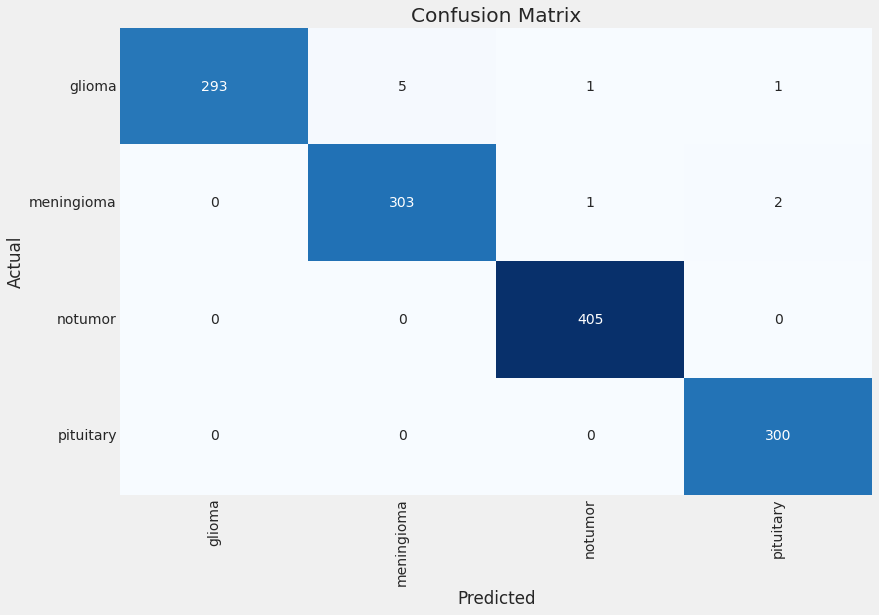

Classification Report:
----------------------
               precision    recall  f1-score   support

      glioma     1.0000    0.9767    0.9882       300
  meningioma     0.9838    0.9902    0.9870       306
     notumor     0.9951    1.0000    0.9975       405
   pituitary     0.9901    1.0000    0.9950       300

    accuracy                         0.9924      1311
   macro avg     0.9922    0.9917    0.9919      1311
weighted avg     0.9924    0.9924    0.9924      1311



In [57]:
errors, tests, error_list, error_pred_list,y_true,preds,ypred,ytrue =predictor(test_gen, test_steps)

#### Prepare data for ploting ROC Curve

In [58]:
ytrue

array([0, 0, 0, ..., 3, 3, 3])

In [59]:
y_true_onehot = np.zeros((ytrue.size, ytrue.max() + 1))
y_true_onehot[np.arange(ytrue.size), ytrue] = 1

In [60]:
y_true_onehot

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [61]:
preds[0]

array([0.99613684, 0.00155708, 0.00100071, 0.00130538], dtype=float32)

In [62]:
classes=['glioma', 'meningioma', 'notumor', 'pituitary']
classes[0]

'glioma'

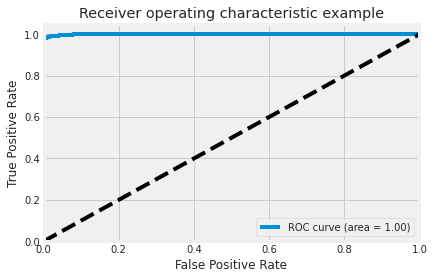

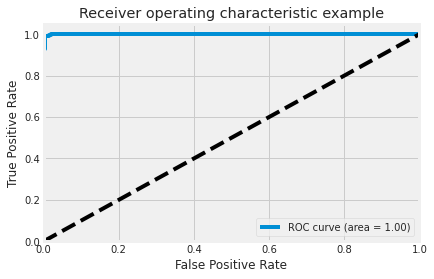

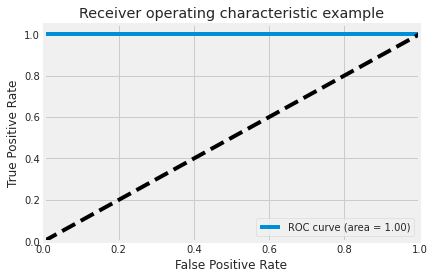

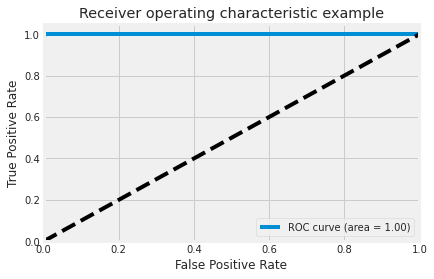

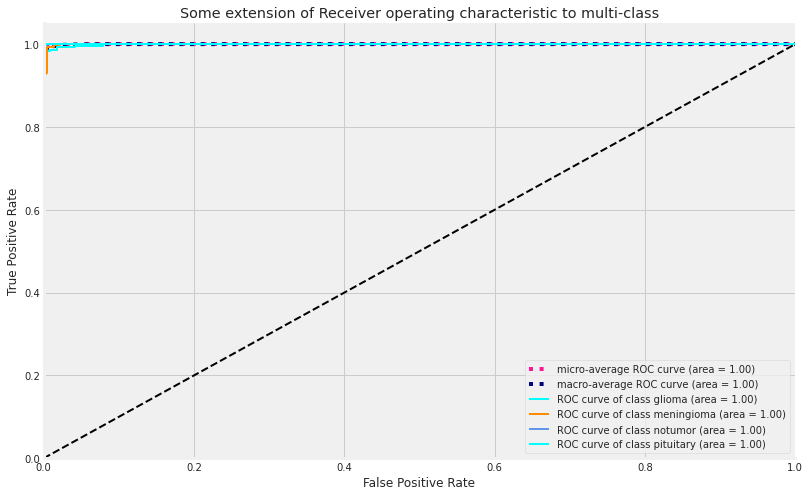

In [63]:
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


y_test = y_true_onehot

n_classes = 4

pred_Y = preds
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_Y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_Y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

classes=['glioma', 'meningioma', 'notumor', 'pituitary']
# Plot all ROC curves
fig = plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
sns.despine()
plt.show()

In [64]:
from tensorflow.keras.utils import load_img, img_to_array

In [72]:
def new_pred_image(img_path,model,target_height,target_width):
  img=cv2.imread(img_path)
  plt.imshow(img)
  image = load_img(img_path, target_size=(target_height, target_width))
  image = img_to_array(image)
  image = np.expand_dims(image, axis=0)
  preds = model.predict(image)[0]
  max_index=np.argmax(preds)
  predicted_class = classes[max_index]
  confidence = round(100 * (np.max(preds[max_index])), 2)
  plt.title(f'Predicted class: {predicted_class} with {confidence}% confidence')

  #print('***************************')
  #print(f'Predicted class: {predicted_class} with {confidence}% confidence')
  #print('***************************')

  return preds, predicted_class, confidence

#### Test model

(array([9.9634629e-01, 1.4671615e-03, 9.3388668e-04, 1.2526771e-03],
       dtype=float32), 'glioma', 99.63)

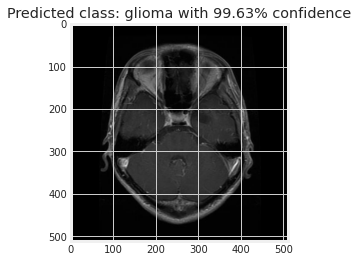

In [73]:
new_pred_image('/content/drive/MyDrive/0_data_science/mri_brain_tumor/Testing/glioma/Te-glTr_0001.jpg',model,270,230)

(array([0.00145415, 0.00193686, 0.9944149 , 0.00219399], dtype=float32),
 'notumor',
 99.44)

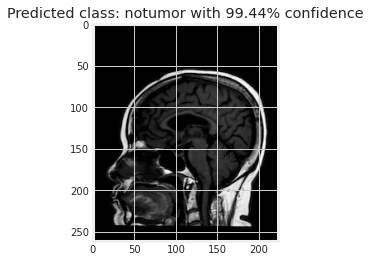

In [74]:
new_pred_image('/content/drive/MyDrive/0_data_science/mri_brain_tumor/Testing/notumor/Te-noTr_0004.jpg',model,270,230)

(array([0.01454976, 0.02651089, 0.01352705, 0.9454123 ], dtype=float32),
 'pituitary',
 94.54)

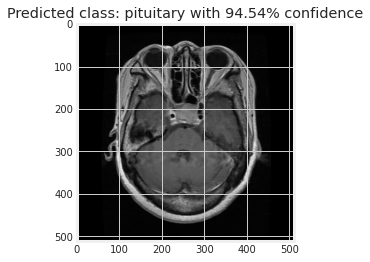

In [75]:
new_pred_image('/content/drive/MyDrive/0_data_science/mri_brain_tumor/Testing/pituitary/Te-pi_0017.jpg',model,270,230)

(array([0.03956177, 0.88617134, 0.03340061, 0.04086621], dtype=float32),
 'meningioma',
 88.62)

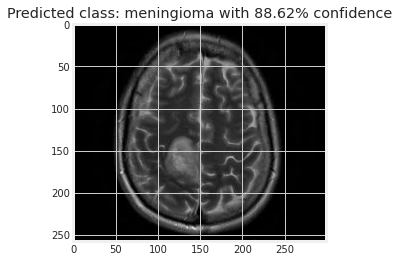

In [76]:
new_pred_image('/content/drive/MyDrive/0_data_science/mri_brain_tumor/Testing/meningioma/Te-me_0037.jpg',model,270,230)

(array([0.00111288, 0.00221623, 0.00107774, 0.99559313], dtype=float32),
 'pituitary',
 99.56)

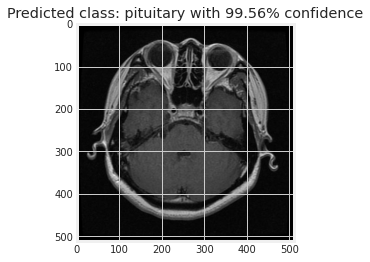

In [77]:
new_pred_image('/content/drive/MyDrive/0_data_science/mri_brain_tumor/Testing/pituitary/Te-pi_0145.jpg',model,270,230)